In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler


2023-05-28 11:32:50.707645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploratory Data Analysis

In [2]:
#Read the data in the directory data, and get the path of the csv files
csv_paths = []
for root, dirs, files in os.walk('data'):
    for file in files:
        if file.endswith('.csv'):
            csv_paths.append(os.path.join(root, file))

# Print the paths of the CSV files
for path in csv_paths:
    print(path)

data/Heating Oil.csv
data/Coffee.csv
data/Lean Hogs.csv
data/Soybean Oil.csv
data/Soybean.csv
data/Sugar.csv
data/Cotton.csv
data/Feeder Cattle.csv
data/RBOB Gasoline.csv
data/Silver.csv
data/Wheat.csv
data/Lumber.csv
data/Soybean Meal.csv
data/Oat.csv
data/Brent Crude Oil.csv
data/Crude Oil.csv
data/Gold.csv
data/Live Cattle.csv
data/Palladium.csv
data/Corn.csv
data/Copper.csv
data/Natural Gas.csv
data/Platinum.csv
data/Cocoa.csv


## Exploratory Data Analysis

For this LSTM exercise, we will only look at the lumber price

In [3]:
#Read the csv files into a list of dataframes
df = pd.read_csv("data/Lumber.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-07-17,260.0,260.500000,251.500000,251.500000,251.500000,446.0
1,2000-07-18,248.0,254.000000,247.500000,253.300003,253.300003,362.0
2,2000-07-19,250.5,254.300003,248.500000,253.699997,253.699997,861.0
3,2000-07-20,254.0,256.500000,243.699997,243.699997,243.699997,973.0
4,2000-07-21,241.5,253.699997,240.199997,249.399994,249.399994,449.0


In [4]:
#Check the input data type of each column
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [5]:
#Let's change the Date column to a datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

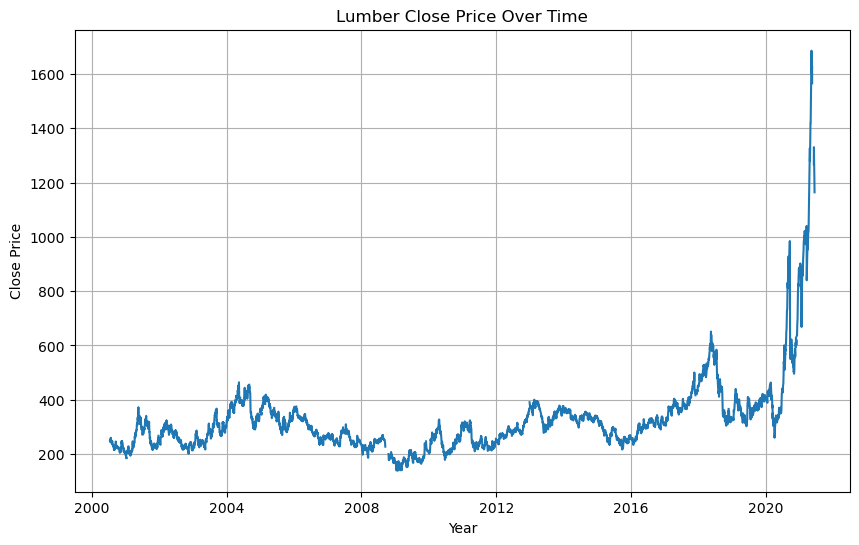

In [6]:
# Plotting the close price against the index
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.grid(True)
plt.show()

In [7]:
#It seems some of the data are missing, let's check the missing values
df.isnull().sum()

Date           0
Open         129
High         129
Low          129
Close        129
Adj Close    129
Volume       129
dtype: int64

In [8]:
# We will see which year are these missing data from
df[df['Close'].isnull()].groupby(df['Date'].dt.year).size()


Date
2000     3
2001     9
2002     9
2003     8
2004    11
2005     8
2006    11
2007     6
2008    28
2009     2
2010     1
2011     1
2012     3
2013     4
2014     3
2016     2
2017     2
2018     3
2019     3
2020     2
2021    10
dtype: int64

More data are missing from year 2008 or before, we will drop those data.
With reference to the above plot, it is noted the lumber price has also moved beyond its normal range since 2020 when pandemic strikes, we will also remove the data from 2020.

In [9]:
df = df[(df['Date'].dt.year >= 2009) & (df['Date'].dt.year <= 2019)]
df[df['Close'].isnull()].groupby(df['Date'].dt.year).size()

Date
2009    2
2010    1
2011    1
2012    3
2013    4
2014    3
2016    2
2017    2
2018    3
2019    3
dtype: int64

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2192,2009-01-02,168.699997,171.800003,168.300003,169.000000,169.000000,0.0
2193,2009-01-05,170.000000,170.000000,164.000000,164.300003,164.300003,0.0
2194,2009-01-06,163.600006,168.500000,162.199997,168.199997,168.199997,0.0
2195,2009-01-07,167.899994,168.899994,164.100006,164.600006,164.600006,0.0
2196,2009-01-08,164.800003,164.800003,159.800003,161.199997,161.199997,0.0


Now we will define a function to remove all relevant columns, and add a column for log return.

In [11]:
def add_pct_change(df):
    '''Remove all relevant columns, return two columns of the dataframe: Close and log_return'''
    df.index = df['Date']
    df = df[['Close']]
    df_pct_change = df.pct_change()
    df_pct_change_log = np.log(1 + df_pct_change)
    df_pct_change_log.rename(columns={'Close': 'log_return'}, inplace=True)
    df = pd.concat([df, df_pct_change_log], axis=1)
    df.dropna(inplace=True)
    return df

In [12]:
df = add_pct_change(df)
df.head()

,Close,log_return
Date,,
2009-01-05,164.300003,-0.028205
2009-01-06,168.199997,0.023460
2009-01-07,164.600006,-0.021635
2009-01-08,161.199997,-0.020873
2009-01-09,162.100006,0.005568


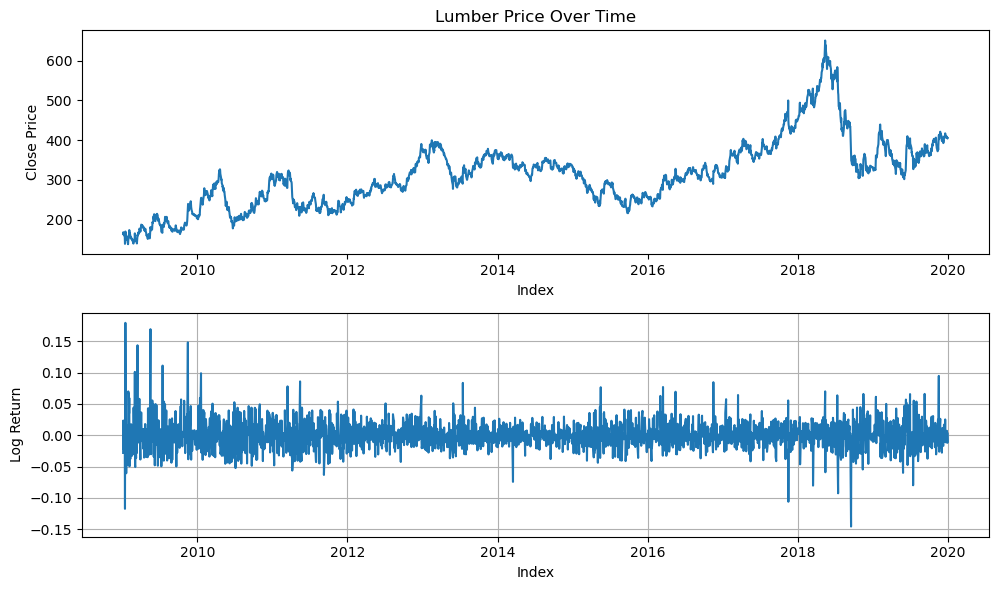

In [13]:
#Have a glance on the two columns
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'])
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Lumber Price Over Time')

plt.subplot(2, 1, 2)
plt.plot(df.index, df['log_return'])
plt.xlabel('Index')
plt.ylabel('Log Return')

plt.tight_layout()
plt.grid(True)
plt.show()

### Train Test Split

We will adjust the format for input(X) and output(y).

In [14]:
X = df[['Close', 'log_return']].values

In [16]:
#Apply MinMaxScaler to both columns
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[0.05108208, 0.36131751],
       [0.05868589, 0.52036122],
       [0.05166699, 0.38154036],
       [0.045038  , 0.38388885],
       [0.04679275, 0.46528233]])

In [17]:
#Out target variable is also the close price (the first column of X)
y = np.array([x[0] for x in X_scaled])
y[:5]

array([0.05108208, 0.05868589, 0.05166699, 0.045038  , 0.04679275])

X_train shape: (2469, 2)
X_val shape: (137, 2)
X_test shape: (138, 2)
y_train shape: (2469,)
y_val shape: (137,)
y_test shape: (138,)


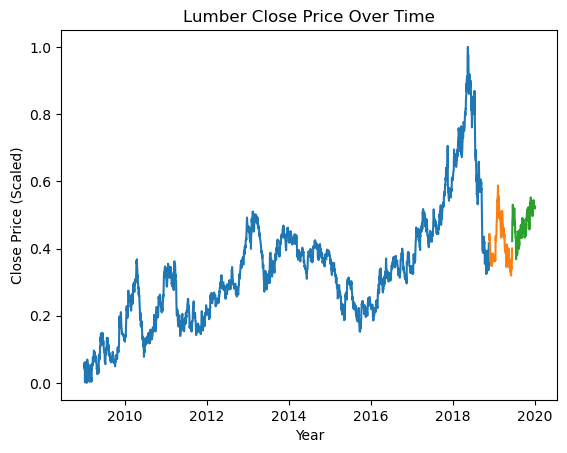

In [54]:
#We will then use the first 90% of the data as training data, 5% as validation, 5% as test data
q_90 = int(len(X) * .9)
q_95 = int(len(X) * .95)

date_train = df.index[:q_90]
date_val = df.index[q_90:q_95]
date_test = df.index[q_95:]

X_train = X_scaled[:q_90]
X_val = X_scaled[q_90:q_95]
X_test = X_scaled[q_95:]

y_train = y[:q_90]
y_val = y[q_90:q_95]
y_test = y[q_95:]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

plt.plot(date_train, y_train)
plt.plot(date_val, y_val)
plt.plot(date_test, y_test)
plt.ylabel('Close Price (Scaled)')
plt.xlabel('Year')
plt.title('Lumber Close Price Over Time')
plt.show()


Looking good we will now define a function for the above code, such that it can take different rolling window.

In [55]:
#We will use a windowed dataset to train the model
def windowed_df(n=3):
    X_train = X_scaled[:q_90]
    X_val = X_scaled[q_90:q_95]
    X_test = X_scaled[q_95:]

    y_train = y[:q_90]
    y_val = y[q_90:q_95]
    y_test = y[q_95:]

    date_train = df.index[:q_90]
    date_val = df.index[q_90:q_95]
    date_test = df.index[q_95:]
    
    Xtrain=[]
    ytrain=[]
    Xval=[]
    yval=[]
    Xtest = []
    ytest = []

    for i in range (n,len(X_train)):
        Xtrain.append(X_train[i-n:i,:X_train.shape[1]])
        ytrain.append(y_train[i])
    for i in range (n,len(X_val)):
        Xval.append(X_val[i-n:i,:X_val.shape[1]])
        yval.append(y_val[i])
    for i in range (n,len(X_test)):
        Xtest.append(X_test[i-n:i,:X_test.shape[1]])
        ytest.append(y_test[i])   
    
    X_train, y_train = np.array(Xtrain), np.array(ytrain)
    print(f"X_train shape:{X_train.shape}, y_train shape{y_train.shape}")
    X_val, y_val = np.array(Xval), np.array(yval)
    print(f"X_val shape:{X_val.shape}, y_val shape{y_val.shape}")
    X_test, y_test = np.array(Xtest), np.array(ytest)
    print(f"X_test shape:{X_test.shape}, y_test shape{y_test.shape}")
    
    date_train = date_train[n:]
    date_val = date_val[n:]
    date_test = date_test[n:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, date_train, date_val, date_test

In [56]:
X_train, y_train, X_val, y_val, X_test, y_test, date_train, date_val, date_test = windowed_df(n=3)

X_train shape:(2466, 3, 2), y_train shape(2466,)
X_val shape:(134, 3, 2), y_val shape(134,)
X_test shape:(135, 3, 2), y_test shape(135,)


In [57]:
#We will then see if the MinMaxScaler works as expected, by comparing the first input 4 to 10 (first 3 inputs are used to predict the 4th input)
df.head(10)

,Close,log_return
Date,,
2009-01-05,164.300003,-0.028205
2009-01-06,168.199997,0.023460
2009-01-07,164.600006,-0.021635
2009-01-08,161.199997,-0.020873
2009-01-09,162.100006,0.005568
2009-01-12,158.300003,-0.023721
2009-01-13,156.300003,-0.012715
2009-01-14,139.000000,-0.117303
2009-01-15,142.100006,0.022057


In [58]:
#Let's check if our y_train is correct, by inverse transform the scaled y_train and see if it matches the original y_train
scale_y = MinMaxScaler()
scale_y.min_, scale_y.scale_ = scaler.min_[0], scaler.scale_[0]
scale_y.inverse_transform(y_train.reshape(-1, 1)).flatten()[:7]

array([161.199997, 162.100006, 158.300003, 156.300003, 139.      ,
       142.100006, 170.      ])

They are identical, we can continue with model training.

## Model Training

In [59]:
#We will first define a simply LSTM model
model = Sequential([layers.Input((X_train.shape[1], X_train.shape[2])),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[early_stopping], verbose=1)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 32)                4480      
                                                                 
 dense_91 (Dense)            (None, 32)                1056      
                                                                 
 dense_92 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


2023-05-28 12:53:00.431876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:53:00.435470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:53:00.438089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2023-05-28 12:53:01.090500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:53:01.095436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:53:01.100492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

74/78 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.1282

2023-05-28 12:53:04.844905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:53:04.848815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:53:04.851448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

78/78 [==============================] - 4s 16ms/step - loss: 0.0320 - mean_absolute_error: 0.1260 - val_loss: 0.0023 - val_mean_absolute_error: 0.0376
Epoch 2/200
78/78 [==============================] - 1s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0240 - val_loss: 3.6756e-04 - val_mean_absolute_error: 0.0152
Epoch 3/200
78/78 [==============================] - 1s 9ms/step - loss: 2.2956e-04 - mean_absolute_error: 0.0112 - val_loss: 3.4923e-04 - val_mean_absolute_error: 0.0149
Epoch 4/200
78/78 [==============================] - 1s 9ms/step - loss: 2.0838e-04 - mean_absolute_error: 0.0106 - val_loss: 3.1550e-04 - val_mean_absolute_error: 0.0141
Epoch 5/200
78/78 [==============================] - 1s 11ms/step - loss: 1.9445e-04 - mean_absolute_error: 0.0102 - val_loss: 3.3886e-04 - val_mean_absolute_error: 0.0146
Epoch 6/200
78/78 [==============================] - 1s 12ms/step - loss: 1.9104e-04 - mean_absolute_error: 0.0101 - val_loss: 3.0997e-04 - val_mean_absolute_error: 0.

 1/78 [..............................] - ETA: 40s

2023-05-28 12:54:25.766736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:54:25.771215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:54:25.773646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

78/78 [==============================] - 1s 5ms/step
Train MSE: 42.92552321571443


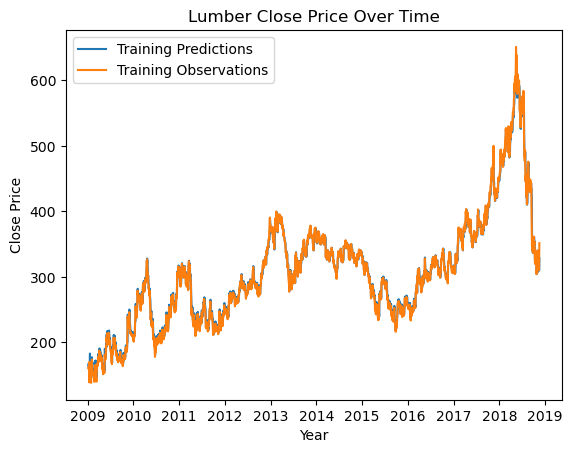

In [60]:
train_predictions = model.predict(X_train).flatten()
train_score = mean_squared_error(scale_y.inverse_transform(y_train.reshape(-1, 1)), scale_y.inverse_transform(train_predictions.reshape(-1, 1)))
print(f"Train MSE: {train_score}")


plt.plot(date_train, scale_y.inverse_transform(train_predictions.reshape(-1, 1)))
plt.plot(date_train, scale_y.inverse_transform(y_train.reshape(-1, 1)))
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.legend(['Training Predictions', 'Training Observations'])

5/5 [==============================] - 0s 3ms/step
Validation MSE: 66.59216836149722


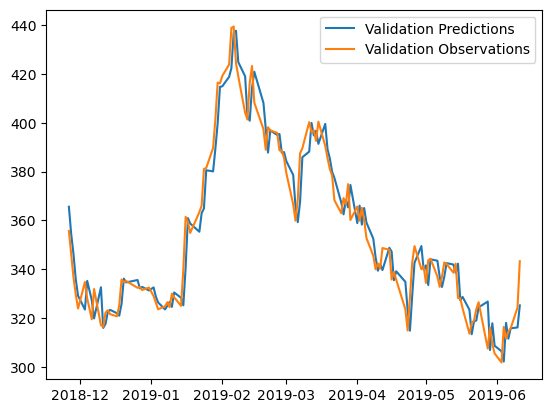

In [61]:
val_predictions = model.predict(X_val).flatten()
val_score = mean_squared_error(scale_y.inverse_transform(y_val.reshape(-1, 1)), scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
print(f"Validation MSE: {val_score}")

plt.plot(date_val, scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
plt.plot(date_val, scale_y.inverse_transform(y_val.reshape(-1, 1)))
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 [==============================] - 0s 22ms/step
Test MSE: 79.30402464991512


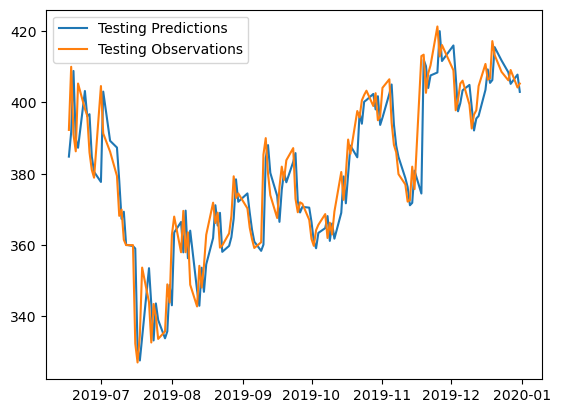

In [62]:
#We will also test it on the test set to see if everything works as expected
test_predictions = model.predict(X_test).flatten()
test_score = mean_squared_error(scale_y.inverse_transform(y_test.reshape(-1, 1)), scale_y.inverse_transform(test_predictions.reshape(-1, 1)))
print(f"Test MSE: {test_score}")

plt.plot(date_test, scale_y.inverse_transform(test_predictions.reshape(-1, 1)))
plt.plot(date_test, scale_y.inverse_transform(y_test.reshape(-1, 1)))
plt.legend(['Testing Predictions', 'Testing Observations'])

Not bad for the first try, we will now set GridSearchCV to optimize the hyperparameters.

In [40]:
def create_model(nodes=32, layers=1, n=3):
    model = Sequential()
    model.add(LSTM(nodes, input_shape=(n, X_train.shape[2])))
    
    for _ in range(layers):
        model.add(Dense(nodes, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', 
                  optimizer='adam',
                  metrics=['mean_absolute_error'])
    
    return model


In [42]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


n_values = [3, 5]  # Define the values of n

results = []  # Store the results for each n

for n in n_values:
    X_train, y_train, X_val, y_val, X_test, y_test, date_train, date_val, date_test = windowed_df(n)
    print(f"For n equals: {n}")

    # Create the KerasRegressor wrapper for GridSearchCV
    model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=32, verbose=1, n=n)

    # Create the GridSearchCV object
    param_grid = {
        'nodes': [16, 32],
        'layers': [1, 2],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')

    # Fit the GridSearchCV object to the data
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

    grid_result = grid_search.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose =0)

    # Get the best model and its performance
    best_model = grid_result.best_estimator_
    best_params = grid_result.best_params_
    best_score = grid_result.best_score_

    # Evaluate the best model on the test set
    test_score = best_model.score(X_test, y_test)

    result = {
        'n': n,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'test_score': test_score
    }

    results.append(result)

# Print the results for each n
for result in results:
    print(f"For n equals: {result['n']}")
    print("Best Model:", result['best_model'])
    print("Best Parameters:", result['best_params'])
    print("Best Score:", result['best_score'])
    print("Test Score:", result['test_score'])
    print()


X_train shape:(2466, 3, 2), y_train shape(2466,)
X_val shape:(134, 3, 2), y_val shape(134,)
X_test shape:(135, 3, 2), y_test shape(135,)
For n equals: 3


/tmp/ipykernel_4305/2050740656.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=32, verbose=1, n=n)
2023-05-28 11:59:42.069749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 11:59:42.072411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/con

 9/26 [=========>....................] - ETA: 0s

2023-05-28 12:00:15.424649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:00:15.427866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:00:15.430120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 6ms/step


2023-05-28 12:00:16.000062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:00:16.003035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:00:16.004789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 7/26 [=======>......................] - ETA: 0s

2023-05-28 12:00:58.991087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:00:58.993569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:00:58.996110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 9ms/step


2023-05-28 12:00:59.576361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:00:59.578221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:00:59.580250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:01:20.252324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:01:20.255066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:01:20.257658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 8ms/step


2023-05-28 12:01:20.780708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:01:20.782511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:01:20.784445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:02:03.790420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:02:03.793631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:02:03.796086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 9ms/step


2023-05-28 12:02:04.349040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:02:04.351607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:02:04.353268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:02:47.354442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:02:47.358160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:02:47.360391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 8ms/step


2023-05-28 12:02:47.887371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:02:47.889869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:02:47.891518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:03:31.671726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:03:31.674534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:03:31.676331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 10ms/step


2023-05-28 12:03:32.272361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:03:32.274946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:03:32.276381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 6/26 [=====>........................] - ETA: 0s

2023-05-28 12:03:51.878870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:03:51.881687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:03:51.884765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 10ms/step


2023-05-28 12:03:52.455762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:03:52.457377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:03:52.460268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:04:18.721625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:04:18.725673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:04:18.727842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 7ms/step


2023-05-28 12:04:19.237558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:04:19.239983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:04:19.241595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:05:02.417540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:05:02.419918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:05:02.423047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 7ms/step


2023-05-28 12:05:02.922757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:05:02.925052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:05:02.927118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:05:46.048283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:05:46.050521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:05:46.052441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 6ms/step


2023-05-28 12:05:46.605777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:05:46.608795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:05:46.610468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:06:29.490102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:06:29.492832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:06:29.495309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:06:30.042574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:06:30.044564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:06:30.046464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:06:53.323035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:06:53.325546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:06:53.327566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 10ms/step


2023-05-28 12:06:53.885790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:06:53.888068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:06:53.889839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 14ms/step - loss: 2.9882e-04 - mean_absolute_error: 0.0132
X_train shape:(2464, 5, 2), y_train shape(2464,)
X_val shape:(132, 5, 2), y_val shape(132,)
X_test shape:(133, 5, 2), y_test shape(133,)
For n equals: 5


/tmp/ipykernel_4305/2050740656.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=32, verbose=1, n=n)
2023-05-28 12:07:37.085262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:07:37.087789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/con

17/26 [==================>...........] - ETA: 0s

2023-05-28 12:08:07.993230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:08:07.996251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:08:07.998425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:08:08.359276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:08:08.361109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:08:08.363014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/26 [==================>...........] - ETA: 0s

2023-05-28 12:08:30.630987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:08:30.633740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:08:30.635729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 4ms/step


2023-05-28 12:08:31.046203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:08:31.048501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:08:31.050647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 2ms/step


2023-05-28 12:09:34.785125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:09:34.787942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:09:34.790315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:10:17.901852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:10:17.905436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:10:17.907545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 4ms/step


2023-05-28 12:10:18.319990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:10:18.322622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:10:18.324122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/26 [==================>...........] - ETA: 0s

2023-05-28 12:11:01.017817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:11:01.021087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:11:01.022745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:11:01.395033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:11:01.397333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:11:01.399208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 8/26 [========>.....................] - ETA: 0s

2023-05-28 12:11:44.151883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:11:44.154262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:11:44.156504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 4ms/step


2023-05-28 12:11:44.553453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:11:44.555775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:11:44.557536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/26 [======================>.......] - ETA: 0s

2023-05-28 12:12:23.971627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:12:23.974559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:12:23.977076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:12:24.355070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:12:24.357415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:12:24.359228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/26 [=================>............] - ETA: 0s

2023-05-28 12:13:48.175059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:13:48.177762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:13:48.179876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:13:48.563914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:13:48.566496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:13:48.567887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:14:33.228008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:14:33.231014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:14:33.233765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 4ms/step


2023-05-28 12:14:33.631502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:14:33.633626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:14:33.635288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:15:17.397656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:15:17.400258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:15:17.402617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step


2023-05-28 12:15:17.955140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:15:17.957789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:15:17.960237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 9s

2023-05-28 12:15:45.354145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:15:45.356373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:15:45.359138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 6ms/step


2023-05-28 12:15:45.934825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:15:45.938266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:15:45.940143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/26 [>.............................] - ETA: 8s

2023-05-28 12:16:03.071093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:16:03.073581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:16:03.075863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 4ms/step


2023-05-28 12:16:03.467129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:16:03.469400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:16:03.473458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 8ms/step - loss: 3.0096e-04 - mean_absolute_error: 0.0132
For n equals: 3
Best Model: <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5b9aaeb1d0>
Best Parameters: {'layers': 2, 'nodes': 32}
Best Score: -0.013774777836096352
Test Score: -0.0002988230553455651

For n equals: 5
Best Model: <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5b7469b1d0>
Best Parameters: {'layers': 1, 'nodes': 16}
Best Score: -0.012238677481102177
Test Score: -0.0003009569481946528



Comparing the final output, the best model has the following parameters:</br>
n = 5</br>
Layers = 1</br>
No. of nodes = 16</br>
We will use this model to make predictions again.

 1/77 [..............................] - ETA: 32s

2023-05-28 12:22:59.755790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:22:59.759408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:22:59.761692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 1s 5ms/step
Train MSE: 41.363571623075394


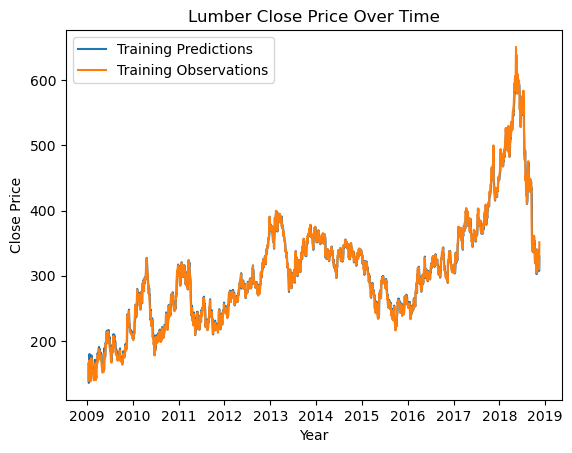

In [43]:
# Extract the best model with n=5 and one layer
best_model_n5 = results[1]['best_model']

# Make predictions on the test set using the best model
train_predictions = best_model_n5.predict(X_train).flatten()
train_score = mean_squared_error(scale_y.inverse_transform(y_train.reshape(-1, 1)), scale_y.inverse_transform(train_predictions.reshape(-1, 1)))
print(f"Train MSE: {train_score}")


plt.plot(date_train, scale_y.inverse_transform(train_predictions.reshape(-1, 1)))
plt.plot(date_train, scale_y.inverse_transform(y_train.reshape(-1, 1)))
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.legend(['Training Predictions', 'Training Observations'])

5/5 [==============================] - 0s 7ms/step


2023-05-28 12:23:04.506884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:23:04.509289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:23:04.511384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Val MSE: 65.45602220744655


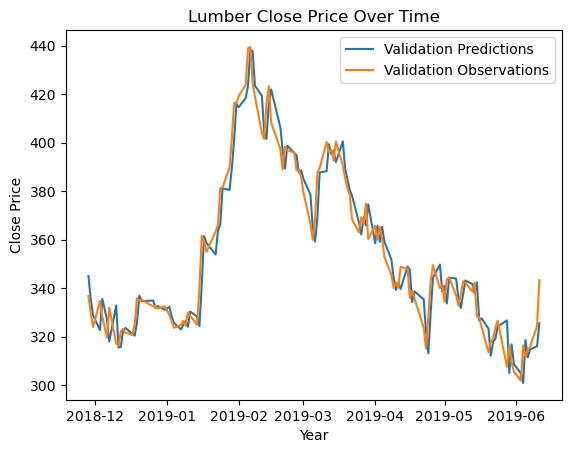

In [44]:
# Make predictions on the val set using the best model
val_predictions = best_model_n5.predict(X_val).flatten()
val_score = mean_squared_error(scale_y.inverse_transform(y_val.reshape(-1, 1)), scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
print(f"Val MSE: {val_score}")


plt.plot(date_val, scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
plt.plot(date_val, scale_y.inverse_transform(y_val.reshape(-1, 1)))
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.legend(['Validation Predictions', 'Validation Observations'])

There is no big difference in MSE on val set from (66.4 vs 65.5), but there seems to have overfitting problem, we will try to introduce dropout to the model with best hyperparameters.

In [48]:
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

X_train, y_train, X_val, y_val, X_test, y_test, date_train, date_val, date_test = windowed_df(5)

dropout_values = [0, 0.01, 0.03, 0.05, 0.1]
best_val_score = float('inf')
best_dropout = None

for dropout in dropout_values:

    # Create a new model with dropout regularization
    best_model_n5_dropout = Sequential()
    best_model_n5_dropout.add(LSTM(16, input_shape=(5, X_train.shape[2])))
    best_model_n5_dropout.add(Dense(16, activation='relu'))
    best_model_n5_dropout.add(Dropout(dropout))  # Add dropout regularization
    best_model_n5_dropout.add(Dense(1))

    best_model_n5_dropout.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

    best_model_n5_dropout.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

    # Train the model with dropout regularization
    history = best_model_n5_dropout.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Make predictions on the validation set using the model with dropout regularization
    val_predictions = best_model_n5_dropout.predict(X_val).flatten()
    val_score = mean_squared_error(scale_y.inverse_transform(y_val.reshape(-1, 1)), scale_y.inverse_transform(val_predictions.reshape(-1, 1)))

    # Update the best dropout and best validation score if necessary
    if val_score < best_val_score:
        best_val_score = val_score
        best_dropout = dropout

print("Best Dropout:", best_dropout)
print("Best Validation MSE:", best_val_score)


X_train shape:(2464, 5, 2), y_train shape(2464,)
X_val shape:(132, 5, 2), y_val shape(132,)
X_test shape:(133, 5, 2), y_test shape(133,)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 16)                1216      
                                                                 
 dense_79 (Dense)            (None, 16)                272       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_80 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:33:08.071121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:33:08.073794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:33:08.076383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

72/77 [===========================>..] - ETA: 0s - loss: 0.0658 - mean_absolute_error: 0.1956

2023-05-28 12:33:10.657847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:33:10.659855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:33:10.663193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 3s 12ms/step - loss: 0.0619 - mean_absolute_error: 0.1866 - val_loss: 0.0032 - val_mean_absolute_error: 0.0448
Epoch 2/200
77/77 [==============================] - 1s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0327 - val_loss: 7.3429e-04 - val_mean_absolute_error: 0.0216
Epoch 3/200
77/77 [==============================] - 1s 8ms/step - loss: 4.9221e-04 - mean_absolute_error: 0.0166 - val_loss: 7.2998e-04 - val_mean_absolute_error: 0.0221
Epoch 4/200
77/77 [==============================] - 1s 7ms/step - loss: 4.4114e-04 - mean_absolute_error: 0.0157 - val_loss: 6.4407e-04 - val_mean_absolute_error: 0.0205
Epoch 5/200
77/77 [==============================] - 1s 8ms/step - loss: 4.1345e-04 - mean_absolute_error: 0.0152 - val_loss: 6.1634e-04 - val_mean_absolute_error: 0.0202
Epoch 6/200
77/77 [==============================] - 1s 7ms/step - loss: 3.8236e-04 - mean_absolute_error: 0.0146 - val_loss: 6.8158e-04 - val_mean_absolute_error: 0.02

2023-05-28 12:34:31.968531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:34:31.971039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:34:31.972912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 16)                1216      
                                                                 
 dense_81 (Dense)            (None, 16)                272       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_82 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:34:32.370313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:34:32.372114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:34:32.373788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

73/77 [===========================>..] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.1188

2023-05-28 12:34:36.150394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:34:36.153901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:34:36.156330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 4s 15ms/step - loss: 0.0280 - mean_absolute_error: 0.1152 - val_loss: 0.0014 - val_mean_absolute_error: 0.0273
Epoch 2/200
77/77 [==============================] - 1s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0242 - val_loss: 6.1055e-04 - val_mean_absolute_error: 0.0198
Epoch 3/200
77/77 [==============================] - 1s 7ms/step - loss: 7.5697e-04 - mean_absolute_error: 0.0176 - val_loss: 5.7220e-04 - val_mean_absolute_error: 0.0194
Epoch 4/200
77/77 [==============================] - 1s 9ms/step - loss: 8.1665e-04 - mean_absolute_error: 0.0178 - val_loss: 5.8296e-04 - val_mean_absolute_error: 0.0198
Epoch 5/200
77/77 [==============================] - 1s 8ms/step - loss: 8.6264e-04 - mean_absolute_error: 0.0174 - val_loss: 5.2804e-04 - val_mean_absolute_error: 0.0184
Epoch 6/200
77/77 [==============================] - 1s 7ms/step - loss: 6.1093e-04 - mean_absolute_error: 0.0162 - val_loss: 5.0208e-04 - val_mean_absolute_error: 0.01

2023-05-28 12:35:57.265238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:35:57.267588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:35:57.269710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 16)                1216      
                                                                 
 dense_83 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_84 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:35:57.571813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:35:57.573788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:35:57.575477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 2s 10ms/step - loss: 0.0412 - mean_absolute_error: 0.1351 - val_loss: 0.0018 - val_mean_absolute_error: 0.0333
Epoch 2/200
 1/77 [..............................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0484

2023-05-28 12:35:59.567560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:35:59.569751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:35:59.572470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0333 - val_loss: 6.9645e-04 - val_mean_absolute_error: 0.0216
Epoch 3/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0259 - val_loss: 6.6987e-04 - val_mean_absolute_error: 0.0213
Epoch 4/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0254 - val_loss: 7.7932e-04 - val_mean_absolute_error: 0.0240
Epoch 5/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0232 - val_loss: 6.0238e-04 - val_mean_absolute_error: 0.0184
Epoch 6/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0234 - val_loss: 6.0893e-04 - val_mean_absolute_error: 0.0184
Epoch 7/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0224 - val_loss: 6.3024e-04 - val_mean_absolute_error: 0.0187
Epoch 8/20

2023-05-28 12:36:41.588250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:36:41.591036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:36:41.593464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 16)                1216      
                                                                 
 dense_85 (Dense)            (None, 16)                272       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:36:41.865425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:36:41.867494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:36:41.869102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 2s 10ms/step - loss: 0.1058 - mean_absolute_error: 0.2654 - val_loss: 0.0176 - val_mean_absolute_error: 0.1208
Epoch 2/200


2023-05-28 12:36:43.839183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:36:43.841128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:36:43.843385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 0s 4ms/step - loss: 0.0160 - mean_absolute_error: 0.0933 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399
Epoch 3/200
77/77 [==============================] - 1s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0499 - val_loss: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 4/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0351 - val_loss: 0.0010 - val_mean_absolute_error: 0.0245
Epoch 5/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0325 - val_loss: 0.0013 - val_mean_absolute_error: 0.0270
Epoch 6/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0328 - val_loss: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 7/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0334 - val_loss: 9.9577e-04 - val_mean_absolute_error: 0.0239
Epoch 8/200
77/77 [===========

2023-05-28 12:37:35.436009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:37:35.438288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:37:35.440362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 16)                1216      
                                                                 
 dense_87 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_88 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:37:35.719663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:37:35.722529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:37:35.723878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 2s 9ms/step - loss: 0.0419 - mean_absolute_error: 0.1469 - val_loss: 0.0043 - val_mean_absolute_error: 0.0538
Epoch 2/200


2023-05-28 12:37:37.701568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:37:37.704353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:37:37.706561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0481 - val_loss: 7.4675e-04 - val_mean_absolute_error: 0.0213
Epoch 3/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0371 - val_loss: 6.8838e-04 - val_mean_absolute_error: 0.0213
Epoch 4/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0365 - val_loss: 6.5911e-04 - val_mean_absolute_error: 0.0205
Epoch 5/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 7.0449e-04 - val_mean_absolute_error: 0.0201
Epoch 6/200
77/77 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - val_loss: 5.9869e-04 - val_mean_absolute_error: 0.0193
Epoch 7/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0337 - val_loss: 5.9035e-04 - val_mean_absolute_error: 0.0188
Epoch 8/20

2023-05-28 12:38:37.134554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:38:37.136658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:38:37.138815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
X_train, y_train, X_val, y_val, X_test, y_test, date_train, date_val, date_test = windowed_df(5)

dropout = 0.1

# Create a new model with dropout regularization
best_model_n5_dropout = Sequential()
best_model_n5_dropout.add(LSTM(16, input_shape=(5, X_train.shape[2])))
best_model_n5_dropout.add(Dense(16, activation='relu'))
best_model_n5_dropout.add(Dropout(dropout))
best_model_n5_dropout.add(Dense(1))

best_model_n5_dropout.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

best_model_n5_dropout.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

# Train the model with dropout regularization
history_dropout = best_model_n5_dropout.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping])


X_train shape:(2464, 5, 2), y_train shape(2464,)
X_val shape:(132, 5, 2), y_val shape(132,)
X_test shape:(133, 5, 2), y_test shape(133,)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 16)                1216      
                                                                 
 dense_89 (Dense)            (None, 16)                272       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_90 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-28 12:40:31.927073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:40:31.929682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:40:31.932579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

73/77 [===========================>..] - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.1799

2023-05-28 12:40:34.855034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:40:34.857410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:40:34.860671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

77/77 [==============================] - 3s 14ms/step - loss: 0.0561 - mean_absolute_error: 0.1754 - val_loss: 0.0073 - val_mean_absolute_error: 0.0722
Epoch 2/200
77/77 [==============================] - 1s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0738 - val_loss: 8.3495e-04 - val_mean_absolute_error: 0.0213
Epoch 3/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0434 - val_loss: 8.9339e-04 - val_mean_absolute_error: 0.0223
Epoch 4/200
77/77 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0420 - val_loss: 6.5645e-04 - val_mean_absolute_error: 0.0190
Epoch 5/200
77/77 [==============================] - 1s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0429 - val_loss: 8.7505e-04 - val_mean_absolute_error: 0.0223
Epoch 6/200
77/77 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0407 - val_loss: 0.0011 - val_mean_absolute_error: 0.0259
Epoch 7/200
77/77

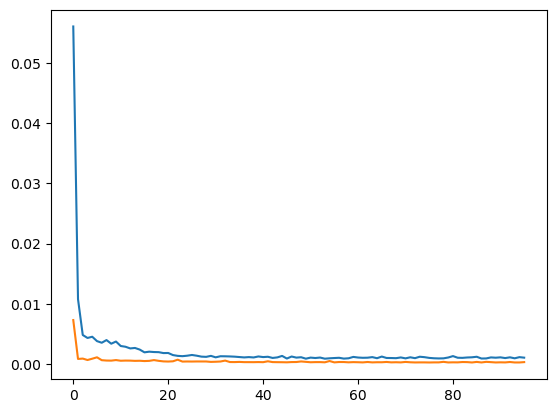

In [63]:
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

1/5 [=====>........................] - ETA: 1s

2023-05-28 12:46:17.213450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 12:46:17.216001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 12:46:17.220127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 10ms/step
Val MSE: 64.9987616549319


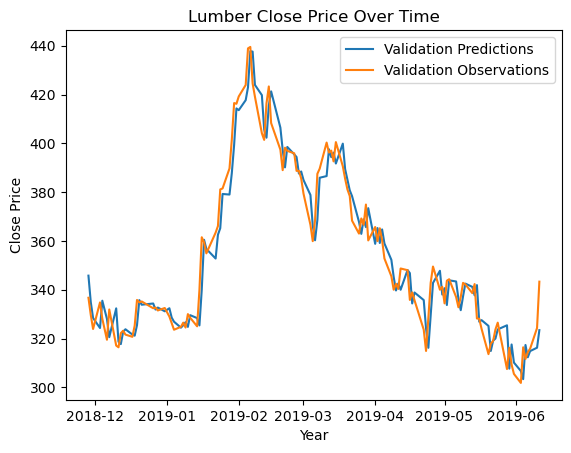

In [51]:
# Make predictions on the val set using the best model
val_predictions = best_model_n5_dropout.predict(X_val).flatten()
val_score = mean_squared_error(scale_y.inverse_transform(y_val.reshape(-1, 1)), scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
print(f"Val MSE: {val_score}")


plt.plot(date_val, scale_y.inverse_transform(val_predictions.reshape(-1, 1)))
plt.plot(date_val, scale_y.inverse_transform(y_val.reshape(-1, 1)))
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 [==============================] - 0s 6ms/step
Test MSE: 77.72496300838931


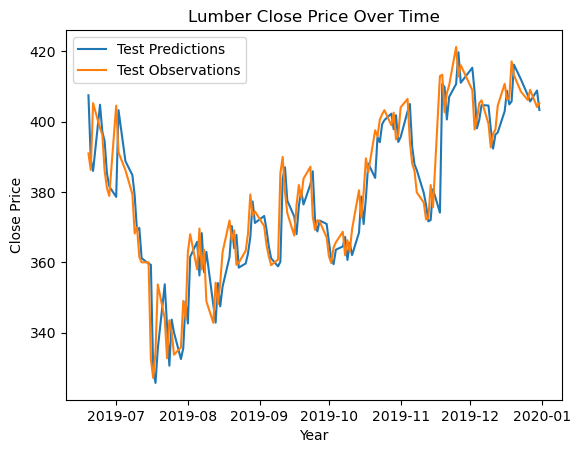

In [52]:
# Make predictions on thetestset using the best model
test_predictions = best_model_n5_dropout.predict(X_test).flatten()
test_score = mean_squared_error(scale_y.inverse_transform(y_test.reshape(-1, 1)), scale_y.inverse_transform(test_predictions.reshape(-1, 1)))
print(f"Test MSE: {test_score}")


plt.plot(date_test, scale_y.inverse_transform(test_predictions.reshape(-1, 1)))
plt.plot(date_test, scale_y.inverse_transform(y_test.reshape(-1, 1)))
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Lumber Close Price Over Time')
plt.legend(['Test Predictions', 'Test Observations'])

## Conclusion

In the final model, with 16 nodes, 1 hidden layer, dropout layer of 0.1, the validation MSE remains nearly unchanged at 65, compared with other models we have built. The test MSE is 77.7, which is slightly lower than our initial trial of 79.3.</br>
To further lower the error, we may train with the followings:
1. Getting a time series of shorter time frame, from daily(what we have in this model) to hours/minutes/seconds.
2. Further feature engineering, like varying the length of rolling window.
3. Adding additional raw data for analysis, like volume.

The LSTM model showcased here serves as an instructive exercise in utilizing advanced techniques to predict future stock/commodity prices. However, it is vital to acknowledge the intricacies of the market and the presence of investment banks and quantitative funds employing sophisticated algorithms for trading. It is unrealistic to harbor the belief that constructing a model alone can easily outperform these established players. It is crucial to approach such endeavors with a realistic perspective, recognizing the challenges involved, rather than expecting immediate financial gains.